In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline
import cv2
import random
from PIL import Image
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, GlobalMaxPooling2D, Dropout
from keras.models import Model
from keras import optimizers
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications import xception

In [ ]:
DATA_DIR = '../input/large-gender-face-dataset/big_face_gender_data'
print(os.listdir(path=DATA_DIR))

In [ ]:
# Use ImageDataGenerator to process input data, attach labels, and prevent overflow ram during training

batch_size = 512
image_shape = (218,178)

def add_noise(img):
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=20,shear_range=0.2,
                                   zoom_range = [0.8, 1.2], horizontal_flip=True,
                                   brightness_range= [0.7, 1.3],width_shift_range=0.2,
                                   height_shift_range=0.2, fill_mode='nearest') #preprocessing_function=add_noise

train = train_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Train',
                                       target_size=image_shape, batch_size=batch_size,
                                       class_mode='binary', color_mode='rgb', shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
val = validation_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Validation',
                                          target_size=image_shape, batch_size=batch_size,
                                          class_mode='binary', color_mode='rgb', shuffle=True)

In [ ]:
img, label = train.next()
print(img[1].shape)

In [ ]:
print('Len(train):',len(train))
print('len(val):', len(val))

In [ ]:
print(train.class_indices)
train.classes

In [ ]:
# Show image
img, label = train.next()

fig = plt.figure(figsize=(15,10))
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(img[i])
    plt.xlabel( int(label[i]))
plt.show()

# Build Model Xception

In [2]:
input_shape = (218, 178, 3)
pre_trained_model = xception.Xception(input_shape=input_shape,include_top=False,weights="imagenet")
for i,layer in enumerate(pre_trained_model.layers):
    print(i,layer.name)
print("\nInput:", pre_trained_model.input)
print("Output:", pre_trained_model.output)

2022-10-29 05:01:36.943579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 05:01:37.108408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 05:01:37.109266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 05:01:37.110881: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 1s 0us/step
0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_ac

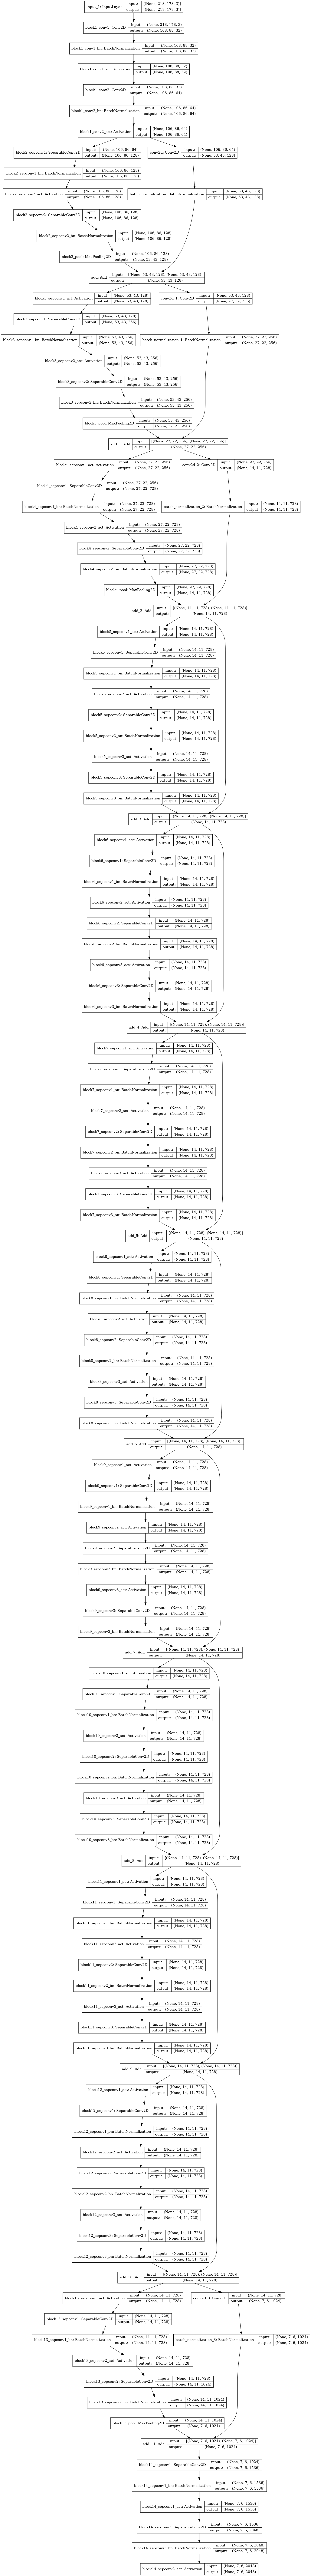

In [3]:
# Visualation architecture
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

# Train Model

In [4]:
input_shape = (218, 178, 3)

pre_trained_model = xception.Xception(input_shape=input_shape,include_top=False,weights="imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = False
last_output = pre_trained_model.output
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)  # Dropout layer to reduce overfitting
# Add a final sigmoid layer for classification
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=pre_trained_model.input, outputs=x)
    
model.compile(keras.optimizers.Adagrad(learning_rate=0.1), 
              loss = 'binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 108, 88, 32)  864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 108, 88, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 108, 88, 32)  0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [10]:
checkpoint = ModelCheckpoint('training_save.h5', verbose=1, mode='auto',
                                              monitor='val_accuracy',  
                                              save_best_only=True)

history = model.fit_generator(
    train, epochs=20,
    validation_data=val,
    verbose=1, callbacks=[checkpoint])

Epoch 1/20


2022-10-29 05:07:50.187186: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 21/355 [>.............................] - ETA: 28:25 - loss: 0.4965 - accuracy: 0.7697

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


355/355 [==============================] - 1918s 5s/step - loss: 0.2670 - accuracy: 0.8892 - val_loss: 0.2150 - val_accuracy: 0.9127

Epoch 00001: val_accuracy improved from -inf to 0.91275, saving model to training_save.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
355/355 [==============================] - 720s 2s/step - loss: 0.2233 - accuracy: 0.9094 - val_loss: 0.2055 - val_accuracy: 0.9166

Epoch 00002: val_accuracy improved from 0.91275 to 0.91663, saving model to training_save.h5
Epoch 3/20
355/355 [==============================] - 711s 2s/step - loss: 0.2146 - accuracy: 0.9134 - val_loss: 0.2003 - val_accuracy: 0.9192

Epoch 00003: val_accuracy improved from 0.91663 to 0.91917, saving model to training_save.h5
Epoch 4/20
355/355 [==============================] - 715s 2s/step - loss: 0.2083 - accuracy: 0.9164 - val_loss: 0.1965 - val_accuracy: 0.9202

Epoch 00004: val_accuracy improved from 0.91917 to 0.92024, saving model to training_save.h5
Epoch 5/20
355/355 [==============================] - 720s 2s/step - loss: 0.2045 - accuracy: 0.9182 - val_loss: 0.1939 - val_accuracy: 0.9212

Epoch 00005: val_accuracy improved from 0.92024 to 0.92125, saving model to training_save.h5
Epoch 6/20
355/355 [==============================] 

In [7]:
np.save('vgg_history.npy',history.history)

In [12]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()


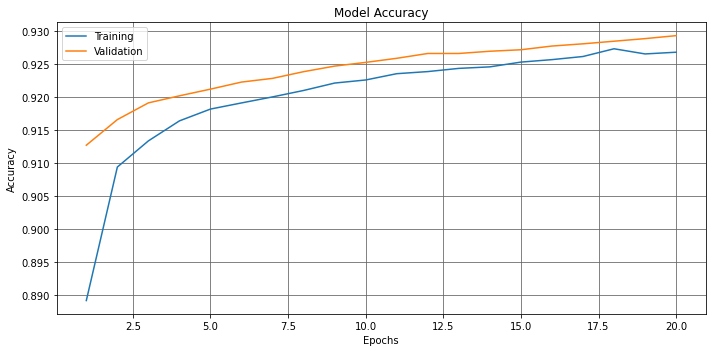

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


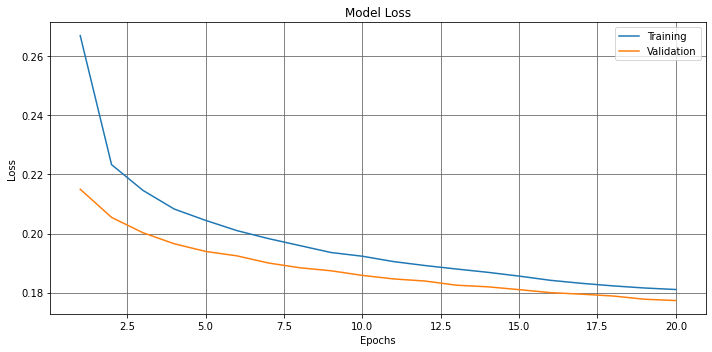

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()


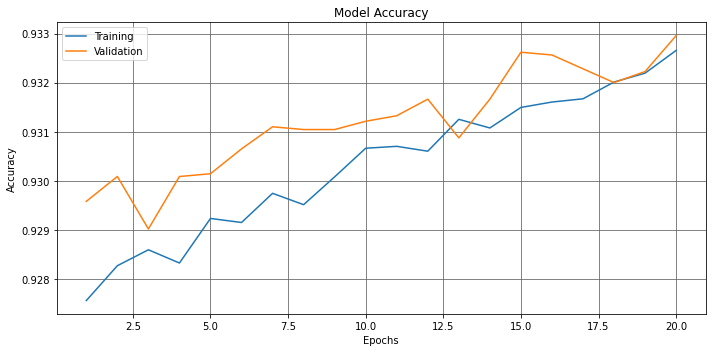

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


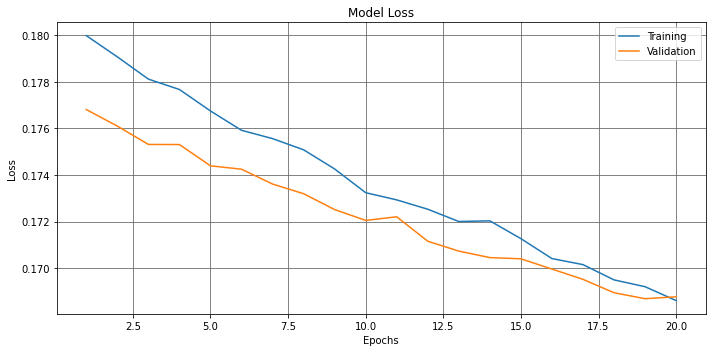

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

In [ ]:
history=np.load('../input/my-data/my_history.npy',allow_pickle='TRUE').item()
history

In [ ]:
acc = history.get('accuracy')
val_acc = history.get('val_accuracy')
loss = history.get('loss')
val_loss = history.get('val_loss')

epochs_range = range(1, len(history.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

# Evaluation on test set

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Test',
                                          target_size=(218,178), batch_size=32,
                                          class_mode='binary', color_mode='rgb', shuffle=False)

Found 16779 images belonging to 2 classes.


In [10]:
predictions = []
labels = []
for i in range(len(test)):
    x, y = next(test)
    pre = model.predict(x)
    pre = [1 if x > 0.5 else 0 for x in pre]
    predictions.append(pre)
    labels.append(y)
predictions = np.concatenate(predictions)
labels = np.concatenate(labels)
print(len(predictions))

16779


              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      8320
         1.0       0.95      0.94      0.94      8459

    accuracy                           0.94     16779
   macro avg       0.94      0.94      0.94     16779
weighted avg       0.94      0.94      0.94     16779

Confusion matrix, without normalization
[[7867  453]
 [ 549 7910]]


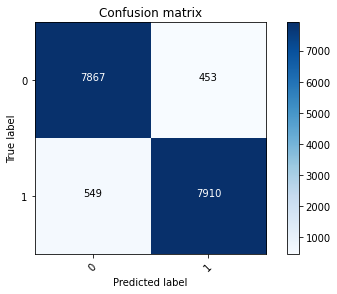

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   
#--------------------------------------------------------------------------------------------------
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(labels, predictions, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(labels, predictions))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],normalize= False,  title='Confusion matrix')

In [12]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


# Tính accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(labels, predictions)
print('Accuracy: %f' % accuracy)
# Tính precision tp / (tp + fp)
precision = precision_score(labels, predictions, average='macro')
print('Precision: %f' % precision)
# Tính recall: tp / (tp + fn)
recall = recall_score(labels, predictions, average='macro')
print('Recall: %f' % recall)
# Tính f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(labels, predictions, average='macro')
print('F1 score: %f' % f1)
# Tính Area under ROC
auc = roc_auc_score(labels, predictions, multi_class='ovr')
print('ROC AUC: %f' % auc)

Accuracy: 0.940282
Precision: 0.940300
Recall: 0.940326
F1 score: 0.940282
ROC AUC: 0.940326


In [18]:
# Saving model
model.save('xception.h5')
print('Done! Model Saved!')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Done! Model Saved!


In [5]:
# Load model
from tensorflow import keras
model = keras.models.load_model('../input/my-data/xception.h5')